3.2 - Solve the problem
Alert incident in transactions: Implement the concept of a simple monitoring with real time alert with notifications to teams.

The monitoring works by receiving information about a transaction and inferring whether it is a failed or denied, or reversed or aprroved transaction. We work mostly with SQL, PromQL, Ruby and Python, but you can use any programming language that you want.

Please use the data of this csv and the data of this csv. Consider that transactions with the flag denied are transactions denied by risk of the issuers. Consider that transactions with the flag reversed or failed are transactions with problems. Note: F1 represents the quantity of transactions per minute from all pos from our costumers. So with this data you can see the diferent status per minute and see if it is going well or not. When you see the padron, you can predict a alarm for the anomaly.

Your Monitoring alert system must have at least: 1 endpoint that receives transaction data and returns a recommendation to “alert” the anomalies found in transactions. A query to organize the data on the data and a graphic to see the data in real time. A model to determine anomalies and a system to report the anomalies automatically.

You are free to determine the methods to approve/deny the transactions, but a few ways to do it are:
- rule-based - you define which cases get alerted based on predefined rules;
- score-base - you create a method/model (you could use machine learning models here if you want) to determine the anomaly -- score of a transaction and make your decision based on it;
- a combination of both;

Monitoring alert Requirements
- Alert transactions if failed transactions are above normal;
- Alert transactions if reversed transactions are above normal;
- Alert transactions if denied transactions are above normal;

In [ ]:
# 1. LER DADOS - OK
# 2. SQL - FILTRAR / TRABALHAR DADOS (QUERY)
#   - FAZER GRÁFICO DE CADA BANCO PARA VER COMPORTAMENTO, É PARECIDO? NÃO? VALE A PENA INTEGRÁ-LOS?
#   - AGRUPAR POR HORA? GRÁFICO MUITO LONGO POR MINUTOS, CONFUSO DE LER ?
#       * SE EU AGRUPO POR HORA PERCO INFORMAÇÕES IMPORTANTES.
#       * PENSAR NA ANÁLISE DO GRÁFICO POR MINUTO E NO ALERTA POR HORA
#   - INTEGRAR DADOS? DAS TABELAS ?
#   - TRAÇAR O GRÁFICO INTEGRADO E TENTAR ENTENDER O PADRÃO
# 3. DEFINIR PREMISSA DOS ALERTAS
#   - FICAR DE OLHO NA EXIGÊNCIAS DO PROBLEMA

# denied ? - Consider that transactions with the flag denied are transactions denied by risk of the issuers. ??? - Alerta: Procure o seu banco
# failed - ALERT
# reversed - ALERT
# aprroved - OK

In [ ]:
import pandas as pd
import pandasql as ps
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv("transactions_2.csv")
data[['hour', 'minutes']] = data.time.str.split("h ", expand = True)
data.head(5)

In [214]:
# STATUS EXISTENTES POR DATA

import pandas as pd
import pandasql as ps
import matplotlib.pyplot as plt

data_1 = pd.read_csv("transactions_1.csv")
data_1[['hour', 'minutes']] = data_1.time.str.split("h ", expand = True)

data_1 = ps.sqldf(f"""
SELECT
    status
FROM
    data_1 AND
    data_2
GROUP BY
    status
""")
print(data_1)

data_2 = pd.read_csv("transactions_2.csv")
data_2[['hour', 'minutes']] = data_2.time.str.split("h ", expand = True)

data_2 = ps.sqldf(f"""
SELECT
    status
FROM
    data_2
GROUP BY
    status
""")
print(data_2)


PandaSQLException: (sqlite3.OperationalError) near "AND": syntax error
[SQL: 
SELECT
    status
FROM
    data_1 AND
    data_2
GROUP BY
    status
]
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [203]:
# GRÁFICO POR MINUTO

def plot_graph_min(doc, status):
    import pandas as pd
    import pandasql as ps
    import matplotlib.pyplot as plt

    data = pd.read_csv(doc)
    data[['hour', 'minutes']] = data.time.str.split("h ", expand = True)

    data = ps.sqldf(f"""
    SELECT
        *
    FROM
        data
    WHERE
        status = '{status}'
    """)

    qt_transactions = data.iloc[:,2].values

    plt.figure(figsize=(20,10))
    plt.plot(qt_transactions, linewidth=2, label=f"{status}")
    plt.title("Transactions x Time", fontweight="bold")
    plt.xlabel("Minutes")
    plt.xticks([])
    plt.ylabel("Transactions")
    plt.legend()
    plt.show()

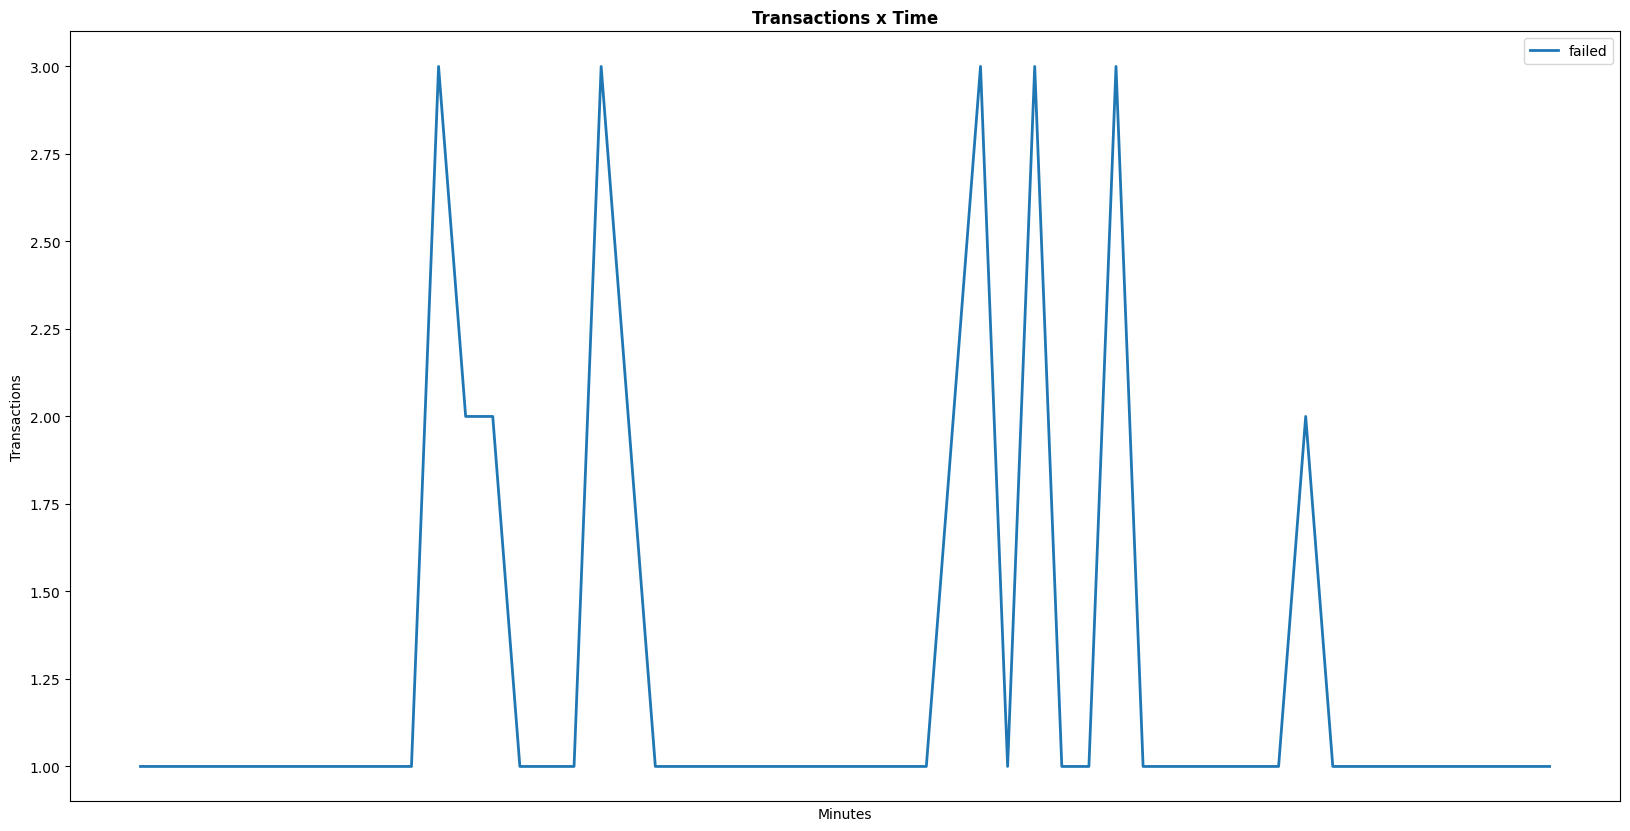

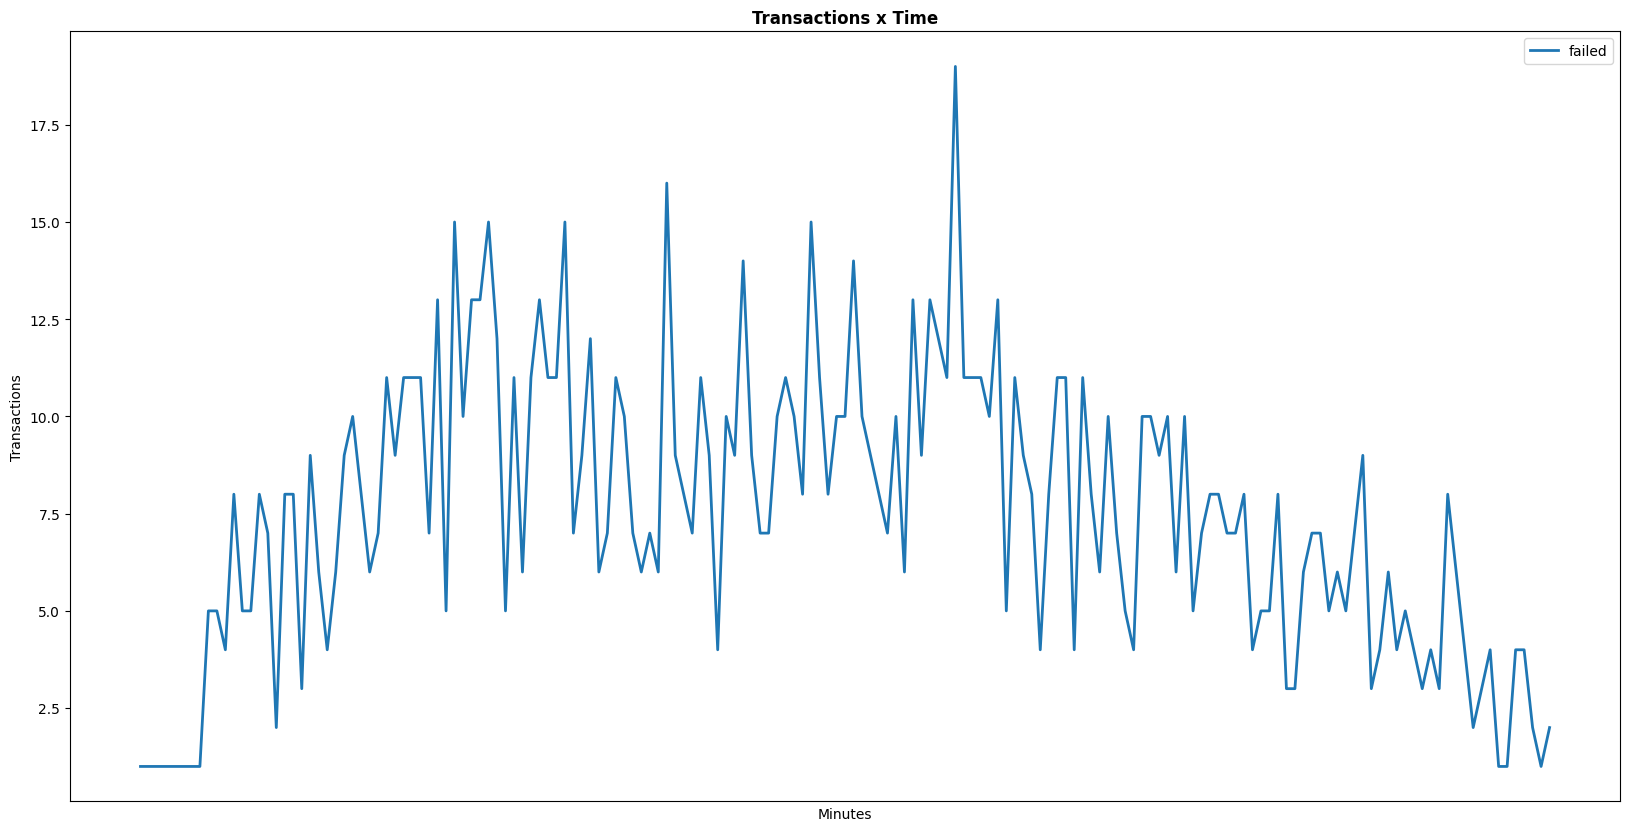

In [207]:
plot_graph_min("transactions_1.csv", "failed")
plot_graph_min("transactions_2.csv", "failed")

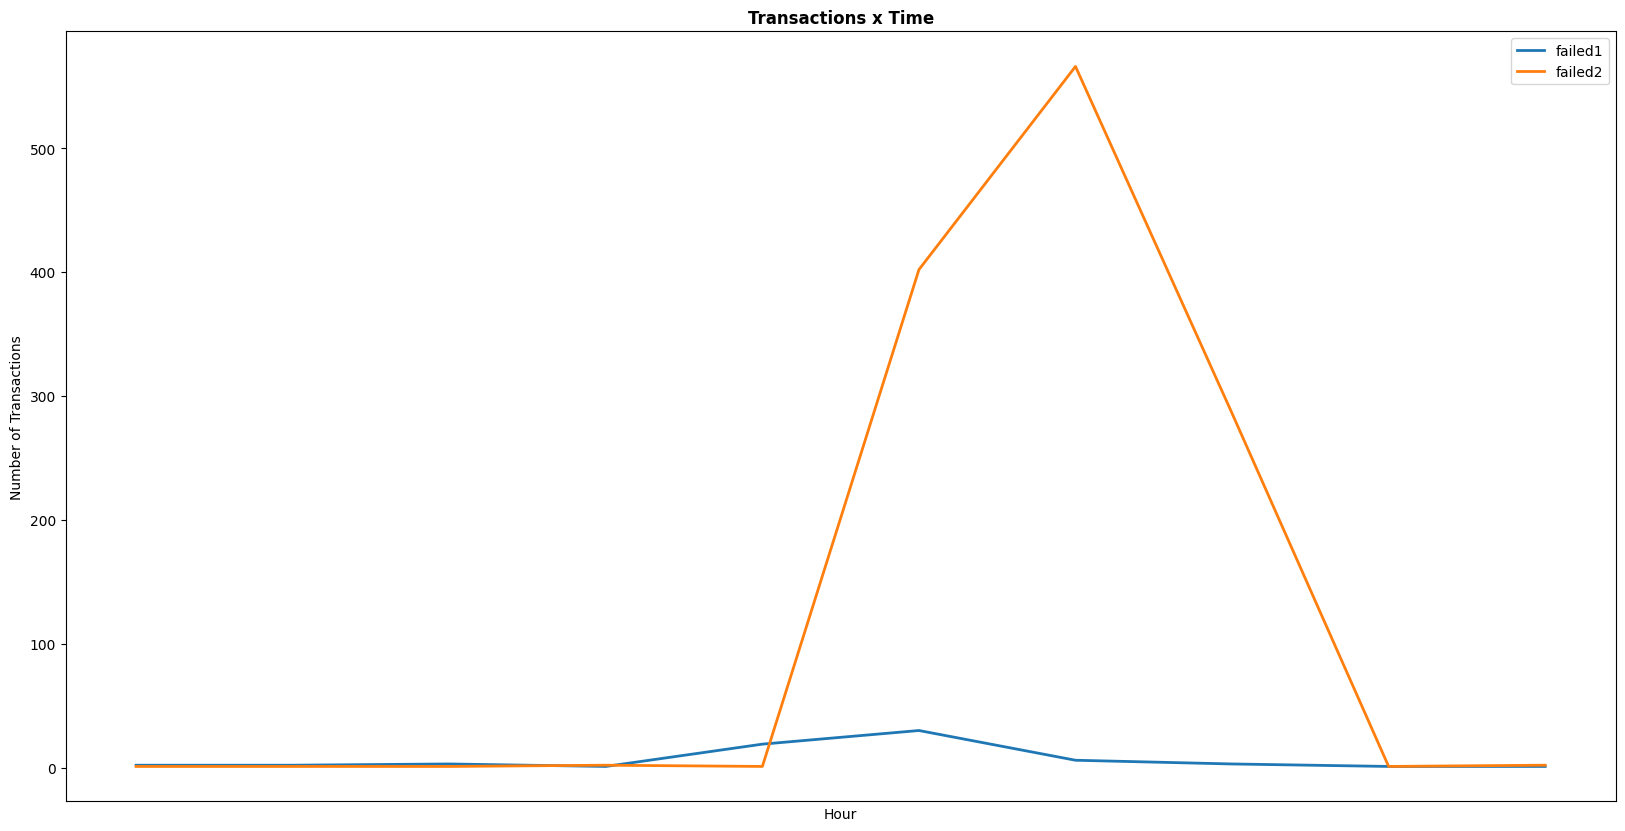

In [195]:
# GRÁFICO FAILED POR HORA (DOIS BANCOS)

import pandas as pd
import pandasql as ps
import matplotlib.pyplot as plt
import numpy as np

data_1 = pd.read_csv("transactions_1.csv")
data_1[['hour', 'minutes']] = data_1.time.str.split("h ", expand = True)
data_1.head(5)

data_2 = pd.read_csv("transactions_2.csv")
data_2[['hour', 'minutes']] = data_2.time.str.split("h ", expand = True)
data_2.head(5)

data_1_failed_h = ps.sqldf("""
SELECT
    SUM (ALL count) AS 'trans/h'
FROM
    data_1
WHERE
    status = 'failed'
GROUP BY
    hour
""")
                             
data_2_failed_h = ps.sqldf("""
SELECT
    SUM (ALL count) AS 'trans/h'
FROM
    data_2
WHERE
    status = 'failed'
GROUP BY
    hour
""")

qt_trans_1_failed_h = data_1_failed_h.iloc[:,0].values
qt_trans_2_failed_h = data_2_failed_h.iloc[:,0].values

plt.figure(figsize=(20,10))
plt.plot(qt_trans_1_failed_h, linewidth=2, label="failed1")
plt.plot(qt_trans_2_failed_h, linewidth=2, label="failed2")
plt.title("Transactions x Time", fontweight="bold")
plt.xlabel("Hour")
plt.xticks([])
plt.ylabel("Transactions")
plt.legend()
plt.show()

* FAZER UM PROGRAMA QUE USA A DATABASE DE INFORMAÇÃO PARA AO RECEBER NOVOS DADOS SABER O QUE FAZER
* NO CASO DÁ PRA MAPEAR O COMPORTAMENTO "NORMAL" BASEADO NO BANCO FORNECIDO
* CRIAR OS ALERTAS DE ACORDO COM ESSE COMPORTAMENTO "NORMAL" DEFINIDO
* GERAR GRÁFICO PARA MELHOR EXPLICAR O MÉTODO
* MEDIANA ? OU MÉDIA

In [176]:
import pandas as pd
import pandasql as ps
import matplotlib.pyplot as plt
import numpy as np

data_1 = pd.read_csv("transactions_1.csv")
data_1[['hour', 'minutes']] = data_1.time.str.split("h ", expand = True)
data_1.head(5)

data_1_total = ps.sqldf("""
SELECT
    SUM (ALL f0_) AS 'total_count'
FROM
    data_1
""")

# CÁLCULO DO % FAILED

data_1_failed = ps.sqldf("""
SELECT
    SUM (ALL f0_) AS 'failed_count'
FROM
    data_1
WHERE
    status = 'failed'
""")

failed_med = round(float((data_1_failed.iloc[:,0].values / data_1_total.iloc[:,0].values)*100), 2)
print(f"O percentual de status 'failed' é de: {failed_med}%")

# CÁLCULO DO % REVERSED

data_1_reversed = ps.sqldf("""
SELECT
    SUM (ALL f0_) AS 'reversed_count'
FROM
    data_1
WHERE
    status = 'reversed'
""")

reversed_med = round(float((data_1_reversed.iloc[:,0].values / data_1_total.iloc[:,0].values)*100), 2)
print(f"O percentual de status 'reversed' é de: {reversed_med}%")

# CÁLCULO DO % DENIED

data_1_denied = ps.sqldf("""
SELECT
    SUM (ALL f0_) AS 'denied_count'
FROM
    data_1
WHERE
    status = 'denied'
""")

denied_med = round(float((data_1_denied.iloc[:,0].values / data_1_total.iloc[:,0].values)*100), 2)
print(f"O percentual de status 'denied' é de: {denied_med}%")

O percentual de status 'failed' é de: 0.03%
O percentual de status 'reversed' é de: 6.32%
O percentual de status 'denied' é de: 10.26%


In [179]:
import pandas as pd
import pandasql as ps
import matplotlib.pyplot as plt
import numpy as np

data_2 = pd.read_csv("transactions_2.csv")
data_2[['hour', 'minutes']] = data_2.time.str.split("h ", expand = True)
data_2.head(5)

data_2_total = ps.sqldf("""
SELECT
    SUM (ALL count) AS 'total_count'
FROM
    data_2
""")

# CÁLCULO DO % FAILED

data_2_failed = ps.sqldf("""
SELECT
    SUM (ALL count) AS 'failed_count'
FROM
    data_2
WHERE
    status = 'failed'
""")

failed_med = round(float((data_2_failed.iloc[:,0].values / data_2_total.iloc[:,0].values)*100), 2)
print(f"O percentual de status 'failed' é de: {failed_med}%")

# CÁLCULO DO % REVERSED

data_2_reversed = ps.sqldf("""
SELECT
    SUM (ALL count) AS 'reversed_count'
FROM
    data_2
WHERE
    status = 'reversed'
""")

reversed_med = round(float((data_2_reversed.iloc[:,0].values / data_2_total.iloc[:,0].values)*100), 2)
print(f"O percentual de status 'reversed' é de: {reversed_med}%")

# CÁLCULO DO % DENIED

data_2_denied = ps.sqldf("""
SELECT
    SUM (ALL count) AS 'denied_count'
FROM
    data_2
WHERE
    status = 'denied'
""")

denied_med = round(float((data_2_denied.iloc[:,0].values / data_2_total.iloc[:,0].values)*100), 2)
print(f"O percentual de status 'denied' é de: {denied_med}%")

O percentual de status 'failed' é de: 0.41%
O percentual de status 'reversed' é de: 0.55%
O percentual de status 'denied' é de: 9.81%
